# 1 - Introduction

Hi, I'm Naufal. This is the notebook for my first classification project. The dataset can be accessed here https://archive.ics.uci.edu/ml/datasets/Bank+Marketing. I used the `bank-additional-full.csv` file. The dataset is related to direct marketing campaign of a Portugese baking institution. The goal of this project is to predict whether or not a customer will subscribe to a term deposit if given a call. 

---
# 2 - Import Libraries

In [126]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import catboost as cb

from scipy.stats.mstats import winsorize
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

---
# 3 - Data Loading

In [127]:
data = pd.read_csv('bank-additional-full.csv', delimiter=';', na_values='unknown')
data1 = data.copy()
data.shape

(41188, 21)

In [128]:
# pd.options.display.max_columns = None

In [129]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Explanation to some of the non self-explanatory columns:
* default : has credit in deafult?
* housing : has housing loan?
* loan : has personal loan?
* month : last contact month 
* day_of_week : last contact day of the week
* duration : last contact duration in seconds
* campaign : number of contacts performed during this campaign and for this client
* pdays : number of days that passed by after the client was last contacted from a previous campaign and for this client
* previous : number of contacts performed before this campaign and for this client
* poutcome : outcome of the previous marketing campaign
* emp.var.rate : employment variation rate (quarterly indicator)
* cons.price.idx : consumer price index (monthly indicator)
* cons.conf.idx : consumer confidence index (monthly indicator)
* euribor3m : euribor 3 month rate (daily indicator)
* nr.employed : number of employees (quarterly indicator)
* y : has the client subscribed a term deposit?

In [130]:
data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [131]:
data.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,40858,41108,39457,32591,40198,40198,41188,41188,41188,41188,41188
unique,11,3,7,2,2,2,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


In [132]:
data.isnull().sum().sum()

12718

---
# 4 - EDA

In [133]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000
duration,41188.0,258.285010,259.279249,0.000,102.000,180.000,319.000,4918.000
campaign,41188.0,2.567593,2.770014,1.000,1.000,2.000,3.000,56.000
pdays,41188.0,962.475454,186.910907,0.000,999.000,999.000,999.000,999.000
previous,41188.0,0.172963,0.494901,0.000,0.000,0.000,0.000,7.000
emp.var.rate,41188.0,0.081886,1.570960,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045
nr.employed,41188.0,5167.035911,72.251528,4963.600,5099.100,5191.000,5228.100,5228.100


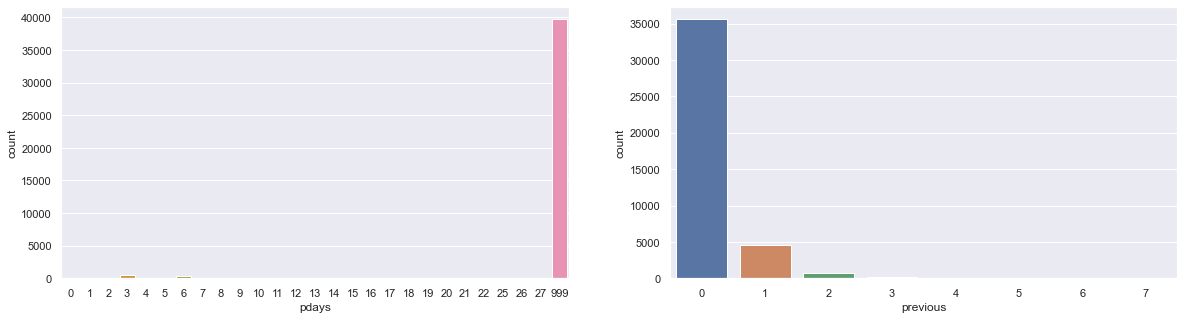

In [134]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
sns.countplot(ax=ax[0], x='pdays', data=data)
sns.countplot(ax=ax[1], x='previous', data=data)
plt.show()

Column 'pdays' and 'previous' are not useful due to having very skewed distribution. Values in 'pdays' are concentrated in 999 while in 'previous' it is concentrated in 0. We will remove these columns.

In [135]:
data = data.drop(['pdays', 'previous'], axis=1)

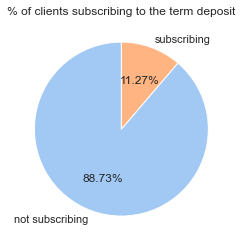

In [136]:
# piechart
colors = sns.color_palette('pastel')
sns.set_theme(style='darkgrid')
plt.pie(data['y'].value_counts(), labels=['not subscribing', 'subscribing'], colors=colors, autopct='%1.2f%%', startangle=90)
plt.title('% of clients subscribing to the term deposit')
plt.show()

Only 11.27% clients subscribed to a term deposit after being contacted. That is equal to just 4,640 out of 36,5548 contacted clients. Imagine the wasted time!

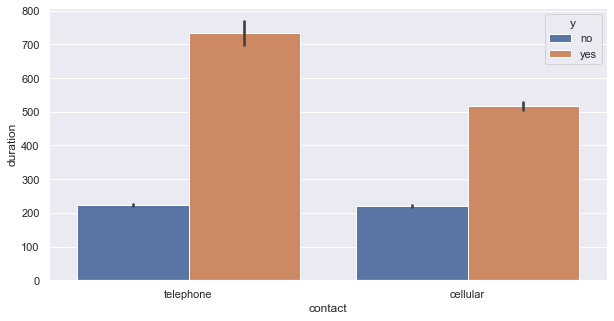

In [137]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='contact', y='duration', hue='y', data=data)
plt.show()

On average, people who are not going to subscribe to a term deposit will hang up the call after 200 seconds. No matter the type of the call, regular telephone call or cellular phone call. 

If we multiply this number with the number of people who are not subscribed to the term deposit, we get 72,181,600 seconds. That is roughly translated to 27 months of 'wasted' time.

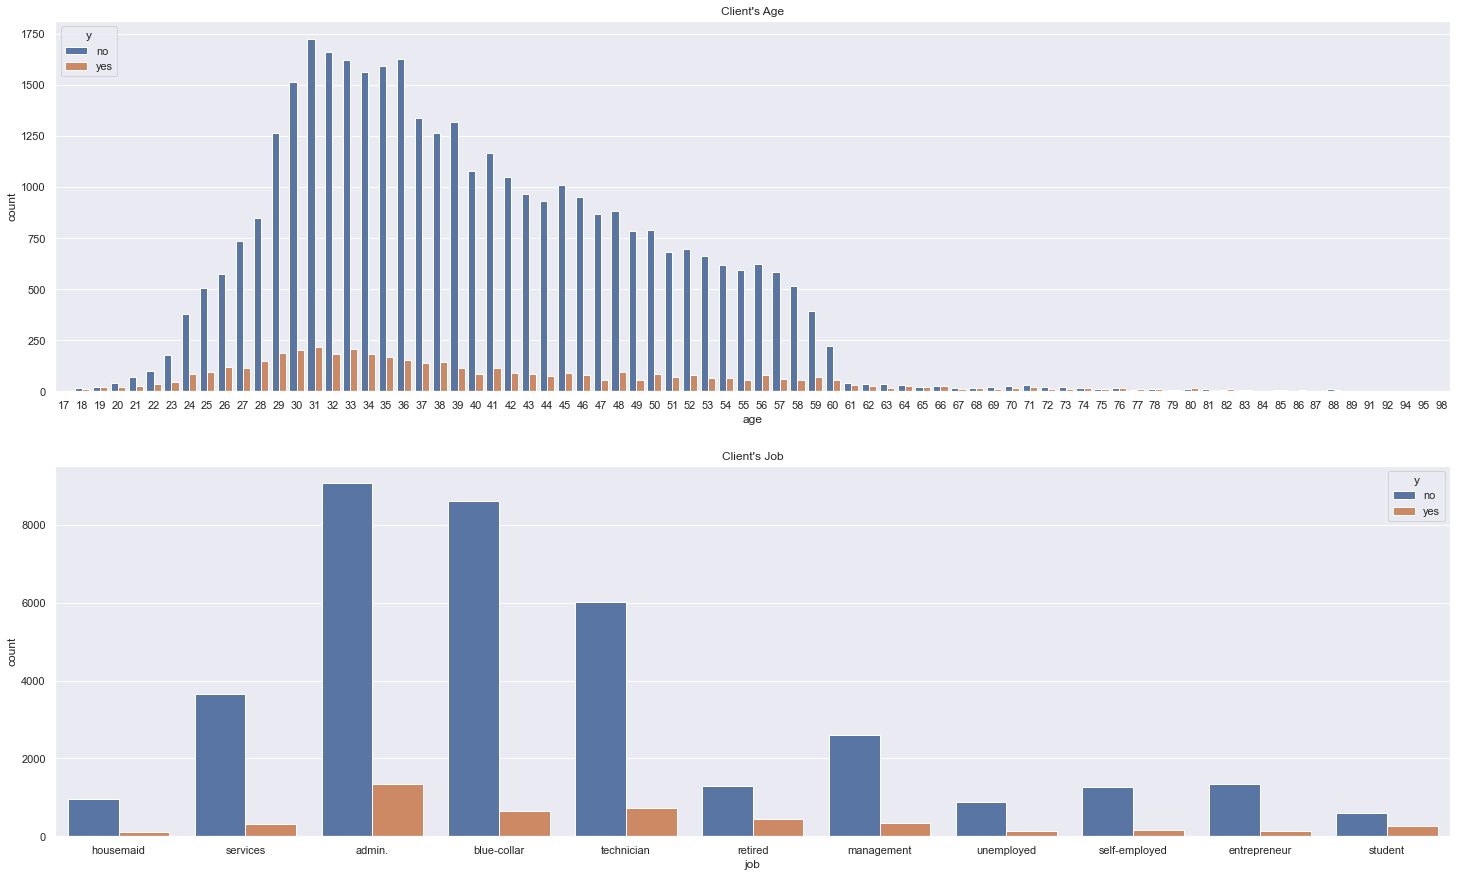

In [138]:
fig, ax = plt.subplots(2, 1, figsize=(25,15))
sns.countplot(ax=ax[0], x='age', hue='y', data=data)
ax[0].set_title('Client\'s Age')
ax[0].xaxis.set_tick_params(rotation=0)
sns.countplot(ax=ax[1], x='job', hue='y', data=data)
ax[1].set_title('Client\'s Job')
ax[1].xaxis.set_tick_params(rotation=0)
plt.show()

The bank contacted people in a very broad range of ages. Starting from 17 to 98 years old. But the people who are subscribed to a term deposit are mostly between 23 and 60 years old.

Most of the people who are subscribed to a term deposit are working in the administrative department.

---
# 5 - Data Preprocessing

## 5.1 - Extract data for model inference

In [139]:
# Data for model inference
data_inf = data.sample(frac=0.01, random_state=69) # 1% of dataset will become the inference set
data_inf.shape

(412, 19)

In [140]:
# remove the inference set from the original dataset
data_train_test = data.drop(data_inf.index)

# resetting index
data.reset_index(drop=True, inplace=True)
data_inf.reset_index(drop=True, inplace=True)

## 5.2 - Split the dataset

In [141]:
# Split data into X (features) and y (target)
X = data_train_test.drop(['y'], axis=1)
y = data_train_test['y']

In [142]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69, stratify=y) # 70% training and 30% test
print('Train set shape:', X_train.shape)
print('Test set shape:', X_test.shape)

Train set shape: (28543, 18)
Test set shape: (12233, 18)


## 5.3 - Handling outlier

In [143]:
# numerical columns in the dataset
num_cols_train = X_train.select_dtypes(include=['int64', 'float64']).columns
num_cols_test = X_test.select_dtypes(include=['int64', 'float64']).columns
print(num_cols_train)

Index(['age', 'duration', 'campaign', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')


In [144]:
# skewness check in X_train
for col in num_cols_train:
    print('column ',col, ' skewness is :', X_train[col].skew())

column  age  skewness is : 0.7685191047870574
column  duration  skewness is : 3.355749549927079
column  campaign  skewness is : 4.6345165182734505
column  emp.var.rate  skewness is : -0.7215019775598686
column  cons.price.idx  skewness is : -0.22726661831069425
column  cons.conf.idx  skewness is : 0.30001413189246484
column  euribor3m  skewness is : -0.7088748481487205
column  nr.employed  skewness is : -1.0439611982636314


In [145]:
# skewness check in X_test
for col in num_cols_test:
    print('column ',col, ' skewness is :', X_test[col].skew())

column  age  skewness is : 0.8154067146631215
column  duration  skewness is : 3.0264375272102013
column  campaign  skewness is : 5.079706876973875
column  emp.var.rate  skewness is : -0.7283487295389336
column  cons.price.idx  skewness is : -0.23831292030196993
column  cons.conf.idx  skewness is : 0.3069414829151594
column  euribor3m  skewness is : -0.7082328936991754
column  nr.employed  skewness is : -1.0423764379329032


In [146]:
# function to find outliers in skewed columns
def find_outliers_skew(df, cols):
    q1, q3 = np.percentile(df[cols], [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    return df[cols][(df[cols] < lower_bound) | (df[cols] > upper_bound)]

#function to find outliers in normal columns
def find_outliers_normal(df, cols):
    out1 = df[cols].mean() + 3*df[cols].std()
    out2 = df[cols].mean() - 3*df[cols].std()
    return df[cols][(df[cols] > out1) | (df[cols] < out2)]

In [147]:
# X_train outliers
# skewed columns
skewed_cols_train = num_cols_train.drop(['cons.price.idx', 'cons.conf.idx'])
# normal columns
norm_cols_train = X_train[['cons.price.idx', 'cons.conf.idx']].columns

for col in skewed_cols_train:
    percentage = find_outliers_skew(X_train, col).shape[0] / X_train.shape[0] * 100
    print(f'Percentage of outliers in {col} : ', percentage)

for col in norm_cols_train:
    percentage = find_outliers_normal(X_train, col).shape[0] / X_train.shape[0] * 100
    print(f'Percentage of outliers in {col} : ', percentage)

Percentage of outliers in age :  1.0895841362155343
Percentage of outliers in duration :  7.210174123252637
Percentage of outliers in campaign :  5.861332025365239
Percentage of outliers in emp.var.rate :  0.0
Percentage of outliers in euribor3m :  0.0
Percentage of outliers in nr.employed :  0.0
Percentage of outliers in cons.price.idx :  0.0
Percentage of outliers in cons.conf.idx :  0.0


In [148]:
# X_test outliers
# skewed columns
skewed_cols_test = num_cols_test.drop(['cons.price.idx', 'cons.conf.idx'])
# normal columns
norm_cols_test = X_test[['cons.price.idx', 'cons.conf.idx']].columns

for col in skewed_cols_test:
    percentage = find_outliers_skew(X_test, col).shape[0] / X_test.shape[0] * 100
    print(f'Percentage of outliers in {col} : ', percentage)

for col in norm_cols_test:
    percentage = find_outliers_normal(X_test, col).shape[0] / X_test.shape[0] * 100
    print(f'Percentage of outliers in {col} : ', percentage)

Percentage of outliers in age :  1.250715278345459
Percentage of outliers in duration :  7.095561186953322
Percentage of outliers in campaign :  5.779449031308755
Percentage of outliers in emp.var.rate :  0.0
Percentage of outliers in euribor3m :  0.0
Percentage of outliers in nr.employed :  0.0
Percentage of outliers in cons.price.idx :  0.0
Percentage of outliers in cons.conf.idx :  0.0


Outliers in column age will be removed since they are just around 1% of the data.

In [149]:
# remove outliers in column age
X_train['age'] = X_train['age'][~(X_train['age'].isin(find_outliers_skew(X_train, 'age')))]
X_test['age'] = X_test['age'][~(X_test['age'].isin(find_outliers_skew(X_test, 'age')))]

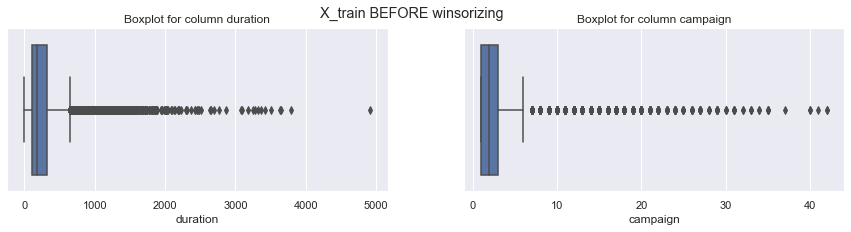

In [150]:
# checking outliers with boxplot
fig, ax = plt.subplots(1, 2, figsize=(15,3))
fig.suptitle('X_train BEFORE winsorizing')
sns.boxplot(ax=ax[0], x='duration', data=X_train)
ax[0].set_title('Boxplot for column duration')
sns.boxplot(ax=ax[1], x='campaign', data=X_train)
ax[1].set_title('Boxplot for column campaign')
plt.show()

Outliers in column campaign will be censored (winsorized) since they are more than 5% of the data.

In [151]:
# handling outliers with winsorize
X_train['duration'] = winsorize(X_train['duration'], limits=(0.05))
X_train['campaign'] = winsorize(X_train['campaign'], limits=(0.05))
X_test['duration'] = winsorize(X_test['duration'], limits=(0.05))
X_test['campaign'] = winsorize(X_test['campaign'], limits=(0.05))

# Handling outliers with removal
# X_train['duration'] = X_train['duration'][~(X_train['duration'].isin(find_outliers_skew(X_train, 'duration')))]
# X_test['duration'] = X_test['duration'][~(X_test['duration'].isin(find_outliers_skew(X_test, 'duration')))]

# X_train['campaign'] = X_train['campaign'][~(X_train['campaign'].isin(find_outliers_skew(X_train, 'campaign')))]
# X_test['campaign'] = X_test['campaign'][~(X_test['campaign'].isin(find_outliers_skew(X_test, 'campaign')))]

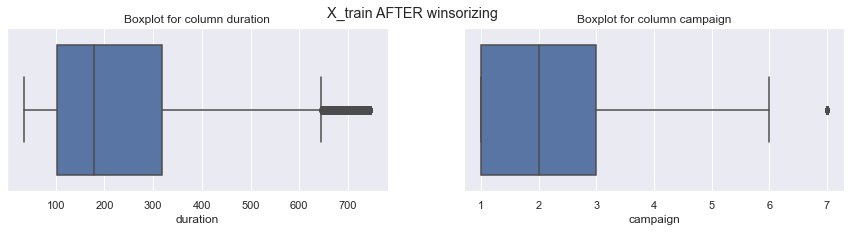

In [152]:
# Boxplot after winsorizing
fig, ax = plt.subplots(1, 2, figsize=(15,3))
fig.suptitle('X_train AFTER winsorizing')
sns.boxplot(ax=ax[0], x='duration', data=X_train)
ax[0].set_title('Boxplot for column duration')
sns.boxplot(ax=ax[1], x='campaign', data=X_train)
ax[1].set_title('Boxplot for column campaign')
plt.show()

## 5.4 - Handling Missing Values

In [153]:
print('Missing values in X_train : ', X_train.isnull().sum().sum())
print('Missing values in X_test : ', X_test.isnull().sum().sum())
print('Missing values in y_train : ', y_train.isnull().sum().sum())
print('Missing values in y_test : ', y_test.isnull().sum().sum())

Missing values in X_train :  9111
Missing values in X_test :  3939
Missing values in y_train :  0
Missing values in y_test :  0


In [154]:
X_train.isnull().sum()

age                311
job                211
marital             56
education         1186
default           6009
housing            669
loan               669
contact              0
month                0
day_of_week          0
duration             0
campaign             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
dtype: int64

In [155]:
X_test.isnull().sum()

age                153
job                118
marital             22
education          524
default           2508
housing            307
loan               307
contact              0
month                0
day_of_week          0
duration             0
campaign             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
dtype: int64

In [156]:
mis_col = ['age', 'job', 'marital', 'education', 'housing', 'loan']

# percentage of missing values
for col in mis_col:
    percentage = X_train[col].isnull().sum() / X_train.shape[0] * 100
    print(f'Percentage of missing values in X_train {col} : ', percentage, '%')

Percentage of missing values in X_train age :  1.0895841362155343 %
Percentage of missing values in X_train job :  0.7392355393616649 %
Percentage of missing values in X_train marital :  0.19619521423816697 %
Percentage of missing values in X_train education :  4.155134358686893 %
Percentage of missing values in X_train housing :  2.343832112952388 %
Percentage of missing values in X_train loan :  2.343832112952388 %


In [157]:
for col in mis_col:
    percentage = X_test[col].isnull().sum() / X_test.shape[0] * 100
    print(f'Percentage of missing values in X_test {col} : ', percentage, '%')

Percentage of missing values in X_test age :  1.250715278345459 %
Percentage of missing values in X_test job :  0.9646039401618572 %
Percentage of missing values in X_test marital :  0.17984141257254965 %
Percentage of missing values in X_test education :  4.283495463091637 %
Percentage of missing values in X_test housing :  2.5096051663533068 %
Percentage of missing values in X_test loan :  2.5096051663533068 %


We will drop the column 'default' since it has too many missing values. Then we will remove the remaining missing values since they are less than 5% of the data and we assume that the mechanism of missing data is MCAR.

In [158]:
# drop column default
X_train = X_train.drop(['default'], axis=1)
X_test = X_test.drop(['default'], axis=1)

In [159]:
# remove missing values
X_train = X_train.dropna()
X_test = X_test.dropna()

In [160]:
# remove corresponding rows in y_train and y_test
y_train = pd.Series(y_train)
y_test = pd.Series(y_test)
y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]

In [161]:
print('Missing values in X_train : ', X_train.isnull().sum().sum())
print('Missing values in X_test : ', X_test.isnull().sum().sum())
print('Missing values in y_train : ', y_train.isnull().sum().sum())
print('Missing values in y_test : ', y_test.isnull().sum().sum())

Missing values in X_train :  0
Missing values in X_test :  0
Missing values in y_train :  0
Missing values in y_test :  0


## 5.5 - Feature Selection

In [162]:
# categorical columns 
catcols = X_train.select_dtypes(include=['object']).columns
print(catcols)
print(' ')
# numerical columns 
numcols = X_train.select_dtypes(include=['int64', 'float64']).columns
print(numcols)

Index(['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month',
       'day_of_week', 'poutcome'],
      dtype='object')
 
Index(['age', 'duration', 'campaign', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')


<AxesSubplot:>

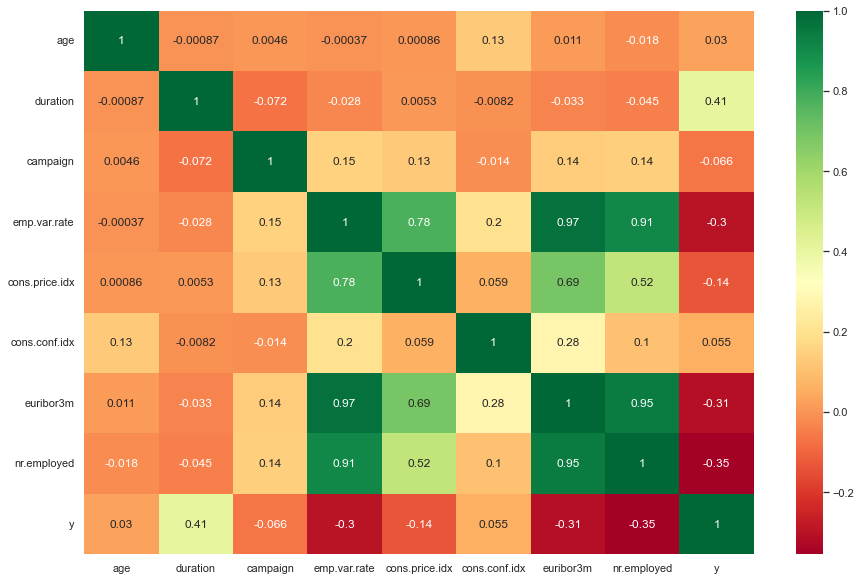

In [163]:
# check correlation between numerical columns and target y
enc = LabelEncoder()

df_num = pd.concat([data[numcols], data['y']], axis=1)
for col in df_num.select_dtypes(include=['object']).columns:
    df_num[col] = enc.fit_transform(df_num[col])

plt.figure(figsize=(15, 10))
sns.heatmap(df_num.corr(), annot=True, cmap='RdYlGn')

Every column has some correlation with the target variable. We will not remove any of them.

In [164]:
# drop column age
# X_train = X_train.drop(['age'], axis=1)
# X_test = X_test.drop(['age'], axis=1)

<AxesSubplot:>

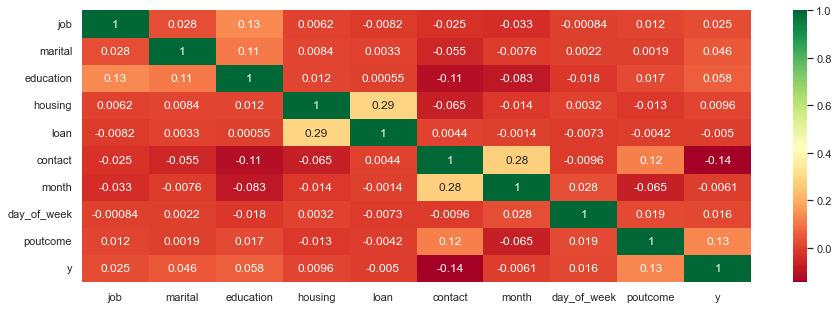

In [165]:
# check correlation between catgeorical columns and target y
df_cat = pd.concat([data[catcols], data['y']], axis=1)
for col in df_cat.select_dtypes(include=['object']).columns:
    df_cat[col] = enc.fit_transform(df_cat[col])

plt.figure(figsize=(15, 5))
sns.heatmap(df_cat.corr(), annot=True, cmap='RdYlGn')

Column loan has relatively low correlation with the target variable. We will remove it.

In [166]:
# drop column loan
X_train = X_train.drop(['loan'], axis=1)
X_test = X_test.drop(['loan'], axis=1)

## 5.6 - Split between numerical and categorical features

In [167]:
# Get Numerical Columns and Categorical Columns
num_columns = X_train.select_dtypes(include=np.number).columns.tolist()
cat_columns = X_train.select_dtypes(include=['object']).columns.tolist()
print('Numerical Columns : ', num_columns)
print('Categorical Columns : ', cat_columns)

Numerical Columns :  ['age', 'duration', 'campaign', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Categorical Columns :  ['job', 'marital', 'education', 'housing', 'contact', 'month', 'day_of_week', 'poutcome']


In [168]:
# Split Train-Set and Test-Set based on Column Type (Numerical/Categorical)
X_train_num = X_train[num_columns]
X_train_cat = X_train[cat_columns]

X_test_num = X_test[num_columns]
X_test_cat = X_test[cat_columns]

## 5.7 - Feature scaling

In [169]:
# Feature Scaling using StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_num)

X_train_num_scaled = scaler.transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

In [170]:
# converting back to dataframe
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns=X_train_num.columns)
X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns=X_test_num.columns)

## 5.8 - Feature encoding

Since column education contains ordinal categorical variables, we should use ordinal encoder for it. The rest of the categorical columns will be encoded using one-hot encoder.

In [171]:
# ordinal encoding to education column
ord = OrdinalEncoder(categories=[['illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree']])
X_train_cat1 = pd.DataFrame(X_train_cat.education)
X_test_cat1 = pd.DataFrame(X_test_cat.education)

ord.fit(X_train_cat1)

X_train_cat1_ord = ord.transform(X_train_cat1)
X_test_cat1_ord = ord.transform(X_test_cat1)

In [172]:
# one hot encoding to other columns
X_train_cat2 = X_train_cat.drop(['education'], axis=1)
X_test_cat2 = X_test_cat.drop(['education'], axis=1)

unique_val = pd.unique(X_train_cat2.values.ravel()) # get all unique values

ohe = OneHotEncoder(categories=[unique_val]*X_train_cat2.shape[1], sparse=False, handle_unknown='ignore', drop='first') # drop first to avoid dummy variable trap

ohe.fit(X_train_cat2)

X_train_cat2_ohe = ohe.transform(X_train_cat2)
X_test_cat2_ohe = ohe.transform(X_test_cat2)

In [173]:
# convert back to dataframe
X_train_cat1_ord = pd.DataFrame(X_train_cat1_ord)
X_test_cat1_ord = pd.DataFrame(X_test_cat1_ord)
X_train_cat2_ohe = pd.DataFrame(X_train_cat2_ohe)
X_test_cat2_ohe = pd.DataFrame(X_test_cat2_ohe)

In [174]:
# get the column names
X_train_cat2_ohe.columns = ohe.get_feature_names_out(input_features=X_train_cat2.columns)
X_test_cat2_ohe.columns = ohe.get_feature_names_out(input_features=X_test_cat2.columns)

## 5.9 - Target encoding

In [175]:
enc = LabelEncoder()
y_train = enc.fit_transform(y_train)
y_test = enc.transform(y_test)

## 5.10 - Concat all

In [176]:
# concatenate all
X_train_final = pd.concat([X_train_num_scaled, X_train_cat1_ord, X_train_cat2_ohe], axis=1)
X_test_final = pd.concat([X_test_num_scaled, X_test_cat1_ord, X_test_cat2_ohe], axis=1)

---
# 6 - Model Definition

The baseline models (using default hyperparameters) :

In [177]:
# logistic regression model
lr = LogisticRegression(max_iter=500)

# SVM model
svc = SVC()

# Decision Tree model
dt = DecisionTreeClassifier()

# Random Forest model
rf = RandomForestClassifier()

# knn model
knn = KNeighborsClassifier()

# Naive Bayes model
nb = GaussianNB()

# AdaBoost model
ada = AdaBoostClassifier()

---
# 7 - Model Training

In [178]:
# train logreg
lr.fit(X_train_final, y_train)

LogisticRegression(max_iter=500)

In [179]:
# train svm
svc.fit(X_train_final, y_train)

SVC()

In [180]:
# train dt
dt.fit(X_train_final, y_train)

DecisionTreeClassifier()

In [181]:
# train rf
rf.fit(X_train_final, y_train)

RandomForestClassifier()

In [182]:
# train knn
knn.fit(X_train_final, y_train)

KNeighborsClassifier()

In [183]:
# train nb
nb.fit(X_train_final, y_train)

GaussianNB()

In [184]:
# train ada
ada.fit(X_train_final, y_train)

AdaBoostClassifier()

---
# 8 - Model Evaluation

## 8.1 - Logistic Regression

In [185]:
# Get Prediction for Logistic Regression
y_pred_train_log = lr.predict(X_train_final)
y_pred_test_log = lr.predict(X_test_final)

In [186]:
# evaluate the model with classification report
print('Logistic Regression')
print('Classification Report on Train Set')
print(classification_report(y_train, y_pred_train_log))

Logistic Regression
Classification Report on Train Set
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     23438
           1       0.65      0.42      0.51      2833

    accuracy                           0.91     26271
   macro avg       0.79      0.70      0.73     26271
weighted avg       0.90      0.91      0.90     26271



From the classification report, we can see that the dataset is imbalanced. The number of class 0 is more than 5x the number of class 1. In that case, we will shift our focus away from accuracy and focus on the f1-score.

The precision, recall and f1-score when class '0' as the positive class are very high compared to when class '1' as the positive class (93%, 97%, 95% compared to 65%, 42%, 51%). It showed in the column support that the instances of class '0' are a lot more than the instances of class '1', almost 10x. So, the model is more accustomed to class '0'. It can easily correctly predict class '0' but not class '1'.

In [187]:
# Cross Validation for Logistic Regression
f1_train_cross_val = cross_val_score(lr, X=X_train_final, y=y_train, cv=3, scoring="f1")

print('f1-score - All - Cross Validation  : ', f1_train_cross_val)
print('f1-score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('f1-score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('f1-score - Range of Test-Set       : ', (f1_train_cross_val.mean()-f1_train_cross_val.std()) , '-', (f1_train_cross_val.mean()+f1_train_cross_val.std()))

f1-score - All - Cross Validation  :  [0.47904192 0.52772467 0.49683143]
f1-score - Mean - Cross Validation :  0.5011993379174277
f1-score - Std - Cross Validation  :  0.020113204092909637
f1-score - Range of Test-Set       :  0.48108613382451804 - 0.5213125420103373


In [188]:
print('Classification Report on Test Set')
print(classification_report(y_test, y_pred_test_log))

Classification Report on Test Set
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      9980
           1       0.63      0.46      0.53      1210

    accuracy                           0.91     11190
   macro avg       0.78      0.71      0.74     11190
weighted avg       0.90      0.91      0.91     11190



The cross validation predicted that the model will have a f1-score between 48.10% to 52.13% on the test set. And the classification report on test set showed f1-score of 53%. It is not far off.

## 8.2 - SVM Classifier

In [189]:
# predict for svm
y_pred_train_svm = svc.predict(X_train_final)
y_pred_test_svm = svc.predict(X_test_final)

In [190]:
# classification report
print('SVM')
print('Classification Report on Train Set')
print(classification_report(y_train, y_pred_train_svm))

SVM
Classification Report on Train Set
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     23438
           1       0.72      0.35      0.47      2833

    accuracy                           0.92     26271
   macro avg       0.82      0.67      0.71     26271
weighted avg       0.90      0.92      0.90     26271



In [191]:
# Cross Validation for svm
f1_train_cross_val = cross_val_score(svc, X=X_train_final, y=y_train, cv=3, scoring="f1")

print('f1-score - All - Cross Validation  : ', f1_train_cross_val)
print('f1-score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('f1-score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('f1-score - Range of Test-Set       : ', (f1_train_cross_val.mean()-f1_train_cross_val.std()) , '-', (f1_train_cross_val.mean()+f1_train_cross_val.std()))

f1-score - All - Cross Validation  :  [0.43727599 0.44364681 0.41353937]
f1-score - Mean - Cross Validation :  0.43148738610022813
f1-score - Std - Cross Validation  :  0.012954931455665434
f1-score - Range of Test-Set       :  0.4185324546445627 - 0.4444423175558936


In [192]:
print('Classification Report on Test Set')
print(classification_report(y_test, y_pred_test_svm))

Classification Report on Test Set
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      9980
           1       0.67      0.35      0.46      1210

    accuracy                           0.91     11190
   macro avg       0.80      0.66      0.70     11190
weighted avg       0.90      0.91      0.90     11190



## 8.3 - Decision Tree

In [193]:
# get prediction for dt
y_pred_train_dt = dt.predict(X_train_final)
y_pred_test_dt = dt.predict(X_test_final)

In [194]:
# classification report
print('Decision Tree')
print('Classification Report on Train Set')
print(classification_report(y_train, y_pred_train_dt))

Decision Tree
Classification Report on Train Set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23438
           1       1.00      1.00      1.00      2833

    accuracy                           1.00     26271
   macro avg       1.00      1.00      1.00     26271
weighted avg       1.00      1.00      1.00     26271



In [195]:
# Cross Validation for dt
f1_train_cross_val = cross_val_score(dt, X=X_train_final, y=y_train, cv=3, scoring="f1")

print('f1-score - All - Cross Validation  : ', f1_train_cross_val)
print('f1-score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('f1-score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('f1-score - Range of Test-Set       : ', (f1_train_cross_val.mean()-f1_train_cross_val.std()) , '-', (f1_train_cross_val.mean()+f1_train_cross_val.std()))

f1-score - All - Cross Validation  :  [0.50131372 0.50444793 0.49871465]
f1-score - Mean - Cross Validation :  0.5014921003874024
f1-score - Std - Cross Validation  :  0.0023439981556154926
f1-score - Range of Test-Set       :  0.49914810223178696 - 0.5038360985430179


In [196]:
print('Classification Report on Test Set')
print(classification_report(y_test, y_pred_test_dt))

Classification Report on Test Set
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      9980
           1       0.49      0.51      0.50      1210

    accuracy                           0.89     11190
   macro avg       0.72      0.72      0.72     11190
weighted avg       0.89      0.89      0.89     11190



## 8.4 - Random Forest

In [197]:
# get prediction for rf
y_pred_train_rf = rf.predict(X_train_final)
y_pred_test_rf = rf.predict(X_test_final)

In [198]:
# classification report
print('Random Forest')
print('Classification Report on Train Set')
print(classification_report(y_train, y_pred_train_rf))

Random Forest
Classification Report on Train Set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23438
           1       1.00      1.00      1.00      2833

    accuracy                           1.00     26271
   macro avg       1.00      1.00      1.00     26271
weighted avg       1.00      1.00      1.00     26271



In [199]:
# Cross Validation for rf
f1_train_cross_val = cross_val_score(rf, X=X_train_final, y=y_train, cv=3, scoring="f1")

print('f1-score - All - Cross Validation  : ', f1_train_cross_val)
print('f1-score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('f1-score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('f1-score - Range of Test-Set       : ', (f1_train_cross_val.mean()-f1_train_cross_val.std()) , '-', (f1_train_cross_val.mean()+f1_train_cross_val.std()))

f1-score - All - Cross Validation  :  [0.46406571 0.46248295 0.45045045]
f1-score - Mean - Cross Validation :  0.45899970188777967
f1-score - Std - Cross Validation  :  0.006079668779043526
f1-score - Range of Test-Set       :  0.45292003310873613 - 0.4650793706668232


In [200]:
print('Classification Report on Test Set')
print(classification_report(y_test, y_pred_test_rf))

Classification Report on Test Set
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      9980
           1       0.63      0.38      0.47      1210

    accuracy                           0.91     11190
   macro avg       0.78      0.68      0.71     11190
weighted avg       0.90      0.91      0.90     11190



## 8.5 - KNN

In [201]:
# get prediction for knn
y_pred_train_knn = knn.predict(X_train_final)
y_pred_test_knn = knn.predict(X_test_final)

In [202]:
# classification report
print('KNN')
print('Classification Report on Train Set')
print(classification_report(y_train, y_pred_train_knn))


KNN
Classification Report on Train Set
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     23438
           1       0.74      0.56      0.64      2833

    accuracy                           0.93     26271
   macro avg       0.85      0.77      0.80     26271
weighted avg       0.93      0.93      0.93     26271



In [203]:
# Cross Validation for knn
f1_train_cross_val = cross_val_score(knn, X=X_train_final, y=y_train, cv=3, scoring="f1")

print('f1-score - All - Cross Validation  : ', f1_train_cross_val)
print('f1-score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('f1-score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('f1-score - Range of Test-Set       : ', (f1_train_cross_val.mean()-f1_train_cross_val.std()) , '-', (f1_train_cross_val.mean()+f1_train_cross_val.std()))

f1-score - All - Cross Validation  :  [0.47530864 0.48618785 0.4665392 ]
f1-score - Mean - Cross Validation :  0.4760118947399676
f1-score - Std - Cross Validation  :  0.008036925986256148
f1-score - Range of Test-Set       :  0.4679749687537114 - 0.48404882072622374


In [204]:
print('Classification Report on Test Set')
print(classification_report(y_test, y_pred_test_knn))

Classification Report on Test Set
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      9980
           1       0.56      0.41      0.47      1210

    accuracy                           0.90     11190
   macro avg       0.74      0.68      0.71     11190
weighted avg       0.89      0.90      0.89     11190



## 8.6 - Naive Bayes

In [205]:
# get prediction for nb
y_pred_train_nb = nb.predict(X_train_final)
y_pred_test_nb = nb.predict(X_test_final)

In [206]:
# classification report
print('Naive Bayes')
print('Classification Report on Train Set')
print(classification_report(y_train, y_pred_train_nb))

Naive Bayes
Classification Report on Train Set
              precision    recall  f1-score   support

           0       0.93      0.92      0.93     23438
           1       0.41      0.47      0.44      2833

    accuracy                           0.87     26271
   macro avg       0.67      0.69      0.68     26271
weighted avg       0.88      0.87      0.87     26271



In [207]:
# Cross Validation for nb
f1_train_cross_val = cross_val_score(nb, X=X_train_final, y=y_train, cv=3, scoring="f1")

print('f1-score - All - Cross Validation  : ', f1_train_cross_val)
print('f1-score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('f1-score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('f1-score - Range of Test-Set       : ', (f1_train_cross_val.mean()-f1_train_cross_val.std()) , '-', (f1_train_cross_val.mean()+f1_train_cross_val.std()))

f1-score - All - Cross Validation  :  [0.4370664  0.44455397 0.42885772]
f1-score - Mean - Cross Validation :  0.43682602842703844
f1-score - Std - Cross Validation  :  0.006410221876529823
f1-score - Range of Test-Set       :  0.4304158065505086 - 0.4432362503035683


In [208]:
print('Classification Report on Test Set')
print(classification_report(y_test, y_pred_test_nb))

Classification Report on Test Set
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      9980
           1       0.42      0.46      0.44      1210

    accuracy                           0.87     11190
   macro avg       0.68      0.69      0.68     11190
weighted avg       0.88      0.87      0.88     11190



## 8.7 - AdaBoost

In [209]:
# get prediction for ada
y_pred_train_ada = ada.predict(X_train_final)
y_pred_test_ada = ada.predict(X_test_final)

In [210]:
# classification report
print('AdaBoost')
print('Classification Report on Train Set')
print(classification_report(y_train, y_pred_train_ada))

AdaBoost
Classification Report on Train Set
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     23438
           1       0.67      0.40      0.50      2833

    accuracy                           0.91     26271
   macro avg       0.80      0.69      0.73     26271
weighted avg       0.90      0.91      0.90     26271



In [211]:
# Cross Validation for ada
f1_train_cross_val = cross_val_score(ada, X=X_train_final, y=y_train, cv=3, scoring="f1")

print('f1-score - All - Cross Validation  : ', f1_train_cross_val)
print('f1-score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('f1-score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('f1-score - Range of Test-Set       : ', (f1_train_cross_val.mean()-f1_train_cross_val.std()) , '-', (f1_train_cross_val.mean()+f1_train_cross_val.std()))

f1-score - All - Cross Validation  :  [0.46457766 0.52439818 0.47337278]
f1-score - Mean - Cross Validation :  0.48744953867006463
f1-score - Std - Cross Validation  :  0.026372207965137874
f1-score - Range of Test-Set       :  0.46107733070492674 - 0.5138217466352025


In [212]:
print('Classification Report on Test Set')
print(classification_report(y_test, y_pred_test_ada))

Classification Report on Test Set
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      9980
           1       0.64      0.39      0.48      1210

    accuracy                           0.91     11190
   macro avg       0.78      0.68      0.72     11190
weighted avg       0.90      0.91      0.90     11190



## 8.8 - Evaluation summary

In [213]:
# summary of f1-score for each model
print('f1-score Logistic Regression : ', np.around(f1_score(y_test, y_pred_test_log), decimals=4))
print('f1-score SVM : ', np.around(f1_score(y_test, y_pred_test_svm), decimals=4))
print('f1-score Decision Tree : ', np.around(f1_score(y_test, y_pred_test_dt), decimals=4))
print('f1-score Random Forest : ', np.around(f1_score(y_test, y_pred_test_rf), decimals=4))
print('f1-score KNN : ', np.around(f1_score(y_test, y_pred_test_knn), decimals=4))
print('f1-score Naive Bayes : ', np.around(f1_score(y_test, y_pred_test_nb), decimals=4))
print('f1-score AdaBoost : ', np.around(f1_score(y_test, y_pred_test_ada), decimals=4))

f1-score Logistic Regression :  0.5285
f1-score SVM :  0.4577
f1-score Decision Tree :  0.5004
f1-score Random Forest :  0.4722
f1-score KNN :  0.4699
f1-score Naive Bayes :  0.4395
f1-score AdaBoost :  0.482


Due to the imbalanced dataset, all of the models are not able to achieve the high f1-score. The model with the highest f1-score is the Logistic Regression.

In [214]:
# AUC metric of each model
print('Logistic Regression AUC Score : ', np.around(roc_auc_score(y_test, y_pred_test_log), decimals=3))
print('SVM AUC Score : ', np.around(roc_auc_score(y_test, y_pred_test_svm), decimals=3))
print('Decision Tree AUC Score : ', np.around(roc_auc_score(y_test, y_pred_test_dt), decimals=3))
print('Random Forest AUC Score : ', np.around(roc_auc_score(y_test, y_pred_test_rf), decimals=3))
print('KNN AUC Score : ', np.around(roc_auc_score(y_test, y_pred_test_knn), decimals=3))
print('Naive Bayes AUC Score : ', np.around(roc_auc_score(y_test, y_pred_test_nb), decimals=3))
print('AdaBoost AUC Score : ', np.around(roc_auc_score(y_test, y_pred_test_ada), decimals=3))

Logistic Regression AUC Score :  0.711
SVM AUC Score :  0.663
Decision Tree AUC Score :  0.723
Random Forest AUC Score :  0.676
KNN AUC Score :  0.683
Naive Bayes AUC Score :  0.693
AdaBoost AUC Score :  0.68


AUC score between 0.5 and 1.0 is good. All of the models exhibited good AUC score. All of them are able to predict more number of True Positives and True Negatives than the False Positives and False Negatives.

## Hyperparameter Tuning with GridSearchCV

Hyperparameter tuning to the best model (Logistic Regression)

In [215]:
# Gridseachcv for Logistic Regression
parameters = {'C': [0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga', 'lbfgs'], 'max_iter' : [500]}

In [216]:
# train with gridsearchcv
logreg_grid = GridSearchCV(estimator=LogisticRegression(), param_grid=parameters, scoring='f1', cv=3)
logreg_grid.fit(X_train_final, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10, 100], 'max_iter': [500],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga', 'lbfgs']},
             scoring='f1')

In [217]:
# get best parameters
logreg_grid.best_params_

{'C': 10, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}

In [218]:
# get best estimator
logreg_grid_best = logreg_grid.best_estimator_

In [219]:
# Check Performance Model against Test-Set
y_pred_test = logreg_grid_best.predict(X_test_final)

print('F1-score - Test Set   : ', np.around(f1_score(y_test, y_pred_test), decimals=3))
print('AUC Score : ', np.around(roc_auc_score(y_test, y_pred_test), decimals=3), '\n')
print('Classification Report : \n', classification_report(y_test, y_pred_test))
#print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(logreg_grid_best, X_test_final, y_test, cmap='Reds'))

F1-score - Test Set   :  0.53
AUC Score :  0.712 

Classification Report : 
               precision    recall  f1-score   support

           0       0.94      0.97      0.95      9980
           1       0.63      0.46      0.53      1210

    accuracy                           0.91     11190
   macro avg       0.78      0.71      0.74     11190
weighted avg       0.90      0.91      0.91     11190



After hyperparameter tuning, the AUC and f1-score slightly increased. The AUC score increased from 71.1% to 71.3% and the f1-score increased from 52.85% to 53.10%.

A hyperparameter tuning can't handle an imbalanced dataset.

## Bonus: CatBoost Classifier

CatBoost is a machine learning algorithm that uses gradient boosting on decision trees. It can uses categorical features directly, without the need of encoding.

In [220]:
# CatBoost model
cat_feat = np.where(X_train.dtypes != np.float)[0]
train_dataset = cb.Pool(X_train,y_train, cat_features=cat_feat)
#cbc = CatBoostClassifier()
cbc = CatBoostClassifier(loss_function='Logloss', eval_metric='F1')

In [221]:
# train catboost
#cbc.fit(X_train, y_train, cat_features=cat_feat, eval_set=(X_test, y_test), plot=True, use_best_model=True)

In [222]:
grid = {'learning_rate': [0.05, 0.1],
'depth': [4, 6, 10],
'l2_leaf_reg': [1, 3, 5,],
'iterations': [50, 100]}

In [223]:
cbc.grid_search(grid,train_dataset) 

0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 42.6ms	remaining: 2.09s
1:	learn: 0.2359882	test: 0.2290749	best: 0.2290749 (1)	total: 79.9ms	remaining: 1.92s
2:	learn: 0.2361624	test: 0.2290749	best: 0.2290749 (1)	total: 125ms	remaining: 1.95s
3:	learn: 0.2402645	test: 0.2332362	best: 0.2332362 (3)	total: 155ms	remaining: 1.78s
4:	learn: 0.2387620	test: 0.2332362	best: 0.2332362 (3)	total: 190ms	remaining: 1.71s
5:	learn: 0.2403528	test: 0.2332362	best: 0.2332362 (3)	total: 217ms	remaining: 1.59s
6:	learn: 0.2409108	test: 0.2332362	best: 0.2332362 (3)	total: 248ms	remaining: 1.52s
7:	learn: 0.2510885	test: 0.2409289	best: 0.2409289 (7)	total: 282ms	remaining: 1.48s
8:	learn: 0.2510885	test: 0.2409289	best: 0.2409289 (7)	total: 322ms	remaining: 1.46s
9:	learn: 0.2516316	test: 0.2405797	best: 0.2409289 (7)	total: 376ms	remaining: 1.5s
10:	learn: 0.2522653	test: 0.2405797	best: 0.2409289 (7)	total: 410ms	remaining: 1.45s
11:	learn: 0.2528070	test: 0.2405797	best: 0.2409289

{'params': {'depth': 6,
  'l2_leaf_reg': 1,
  'iterations': 100,
  'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,

In [224]:
# optimum param found by gridsearch
cbc.get_params()

{'loss_function': 'Logloss',
 'eval_metric': 'F1',
 'depth': 6,
 'l2_leaf_reg': 1,
 'iterations': 100,
 'learning_rate': 0.1}

In [225]:
pred = cbc.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      9980
           1       0.69      0.29      0.40      1210

    accuracy                           0.91     11190
   macro avg       0.80      0.63      0.68     11190
weighted avg       0.89      0.91      0.89     11190



Unfortunately, even after hyperparameter tuning, the f1-score of the CatBoost model is not better than the Logistic Regression's. Once again, the imbalanced dataset needs to be handled in order to achieve high f1-score.

----
# 9 - Model Inference

In [226]:
data_inf.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,40,self-employed,married,university.degree,no,no,no,cellular,aug,fri,144,2,nonexistent,1.4,93.444,-36.1,4.963,5228.1,no
1,38,technician,married,professional.course,no,yes,no,cellular,mar,fri,119,5,nonexistent,-1.8,92.843,-50.0,1.726,5099.1,no
2,47,blue-collar,married,basic.4y,no,no,yes,telephone,may,thu,199,1,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no
3,35,admin.,married,university.degree,no,no,no,telephone,may,wed,41,3,nonexistent,1.1,93.994,-36.4,4.856,5191.0,no
4,50,services,divorced,basic.4y,NaN,no,no,telephone,jun,tue,80,4,nonexistent,1.4,94.465,-41.8,4.864,5228.1,no


In [227]:
data_inf.shape

(412, 19)

## Missing Values

In [228]:
data_inf.isnull().sum()

age                0
job                1
marital            2
education         21
default           80
housing           14
loan              14
contact            0
month              0
day_of_week        0
duration           0
campaign           0
poutcome           0
emp.var.rate       0
cons.price.idx     0
cons.conf.idx      0
euribor3m          0
nr.employed        0
y                  0
dtype: int64

In [229]:
# drop missing values
data_inf = data_inf.dropna()

## Drop low correlation features

In [230]:
# drop column loan
data_inf = data_inf.drop(['loan'], axis=1)

## Split between numerical and categorical 

In [231]:
# Split between Numerical Columns and Categorical Columns
data_inf_num = data_inf[num_columns]
data_inf_cat = data_inf[cat_columns]

## Feature scaling

In [232]:
data_inf_num_scaled = scaler.transform(data_inf_num)

In [233]:
# converting back to dataframe
data_inf_num_scaled = pd.DataFrame(data_inf_num_scaled, columns=data_inf_num.columns)

## Feature encoding

In [234]:
# ordinal encoding to education column
data_inf_cat1 = pd.DataFrame(data_inf_cat.education)
data_inf_cat1_ord = ord.transform(data_inf_cat1)

In [235]:
# one hot encoding to other columns
data_inf_cat2 = data_inf_cat.drop(['education'], axis=1)
data_inf_cat2_ohe = ohe.transform(data_inf_cat2)

In [236]:
# convert back to dataframe
data_inf_cat1_ord = pd.DataFrame(data_inf_cat1_ord)
data_inf_cat2_ohe = pd.DataFrame(data_inf_cat2_ohe)

#get column names
data_inf_cat2_ohe.columns = ohe.get_feature_names_out(input_features=data_inf_cat2.columns)

## Concat all

In [237]:
data_inf_final = pd.concat([data_inf_num_scaled, data_inf_cat1_ord, data_inf_cat2_ohe], axis=1)

In [238]:
data_inf_final

,age,duration,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,0,job_divorced,...,poutcome_student,poutcome_tue,poutcome_retired,poutcome_management,poutcome_services,poutcome_housemaid,poutcome_unemployed,poutcome_mar,poutcome_oct,poutcome_dec
0,0.058670,-0.504970,-0.197019,0.833304,-0.231101,0.985510,0.764746,0.838827,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.150266,-0.635296,1.564087,-1.228725,-1.279742,-2.058444,-1.120624,-0.985567,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.789945,-0.218253,-0.784055,0.639989,0.728553,0.919813,0.704755,0.314137,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.463670,-1.041914,0.390016,0.639989,0.728553,0.919813,0.702425,0.314137,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.372074,1.893029,-0.784055,0.833304,0.595946,-0.459820,0.764164,0.838827,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,1.939092,-1.021062,-0.784055,-1.228725,-1.192501,-1.226284,-1.337293,-0.985567,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
299,0.998881,-0.228679,-0.784055,0.833304,0.595946,-0.459820,0.764164,0.838827,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
300,-0.254734,0.558490,-0.784055,0.833304,1.550366,-0.262730,0.762999,0.838827,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
301,0.581010,0.589768,-0.784055,-1.228725,-0.874942,-1.423374,-1.330886,-0.985567,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Predict Inference set

In [239]:
# predict using best model (Logistic Regression with GridSearchCV)
y_pred_inf_log = logreg_grid.predict(data_inf_final)

In [240]:
# convert to dataframe
y_pred_inf_log_df = pd.DataFrame(y_pred_inf_log, columns=['Pred - y'])

In [241]:
data_inf1 = data_inf.copy()
data_inf1['y'] = data_inf1.y.replace({0: 'No', 1: 'Yes'})

In [242]:
# concat prediction with real data 
print('Logistic Regression')
final_log = pd.concat([data_inf1, y_pred_inf_log_df], axis=1)
final_log[['y', 'Pred - y']].head(31)

Logistic Regression


,y,Pred - y
0,no,0.0
1,no,0.0
2,no,0.0
3,no,0.0
5,no,0.0
6,no,0.0
7,no,0.0
8,no,0.0
9,no,0.0
10,no,0.0


The model is able to predict 'no' correctly most of the time. But when it comes to predict 'yes', the model finds it hard to predict correctly.

---
# 10 - Conclusions

We have built several models to predict the probability of a client to subscribe to a term deposit. The models are: Logistic Regression, SVM Classifier, Decision Tree, Random Forest, KNN, Naive Bayes, AdaBoost and CatBoost. 

All of them are able to achieved high metric score (precision, recall, f1-score) only when class '0' is considered as the positive class. It happened due to imbalanced dataset. Even with hyperparameter tuning, the problem persisted. One way to solve this problem is to do down-sampling or up-sampling (i.e. make the total instances of each class the same). 

Reflecting to the AUC scores, all of the models are still able to predict more number of True Positives and True Negatives than the number of False Positives and False Negatives. In another word, we can choose and use one of the models.

In this project, we have included column duration into our model constructions. However, this column highly affects the output target y. When duration = 0, y = no. Yet, the duration is not known before a call is made. After the end of the call, y obviously becomes known. If the intention were to build a realistic predictive model, we should not include this column.